In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys, os, time, math
sys.path.append('/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj')
import trajCellPoseSr as cellTraj
import h5py
import pandas
import scipy
import string, itertools
from scipy import stats
from scipy.integrate import simps
from datetime import date
import json 
import matplotlib.patches as mpatches

In [2]:
sctm = cellTraj.cellPoseTraj()

In [3]:
trajl = 40
today = date.today()
date2day = today.strftime("%b%d-%Y")
nPCs = 10
nUMP = 0
n_states = 8
wellInfo = 'AwellsComb'
figid = 'LI204601_P_tl'+str(trajl)+'_'+date2day+'_nS'+str(n_states) 

In [4]:
conditions = ['OSM1','EGF1','EGFTGFB1','TGFB1','PBS1','OSMEGFTGFB','OSMEGF','OSMTGFB']
n_conditions = len(conditions)

In [5]:
# read cross-correlations for several ligand conditions 
#path_files = "/home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/decomposeCCtraj_macrostates/" 
filename_cc = "avrg_ccTrjsDcomp_MacStatesLI204601_P_tl"+str(trajl)+wellInfo+"_Apr08-2024_nS"+str(n_states)+".json"
#file_info_cc = path_files + filename_cc 
file_info_cc = filename_cc
# Load the data from the JSON file
with open(file_info_cc, 'r') as file:
    average_cc_values_by_state_and_condition = json.load(file)

In [6]:
n_macStates = len(next(iter(average_cc_values_by_state_and_condition.values())))
# Average CC values for each condition & macrostate
avg_cc_vals_macStates = np.zeros((n_conditions, n_states))  

for condition, states in average_cc_values_by_state_and_condition.items():
    condition_idx = int(condition)
    cc_vals = [avg_cc for state, avg_cc in states.items()]
    avg_cc_vals_macStates[condition_idx, :] = np.array(cc_vals)

bulk_cc_values = np.mean(avg_cc_vals_macStates, axis = 1) # Calculate Bulk CC Values 

In [7]:
inds_dataset = np.zeros(n_conditions).astype(int)
inds = np.where(inds_dataset == 0)[0]
nsamples = inds_dataset.size
tmSet = conditions

In [8]:
# get morphodynamical state probabilities from imaging analysis: To Change
#stProbFile = path_files+'stProbs_LI204601_P_tl'+str(trajl)+wellInfo+'_Apr08-2024'+'_nS'+str(n_states)+'pc'+str(nPCs)+'u'+str(nUMP)+'.dat' 
stProbFile = 'stProbs_LI204601_P_tl'+str(trajl)+wellInfo+'_Apr08-2024'+'_nS'+str(n_states)+'pc'+str(nPCs)+'u'+str(nUMP)+'.dat'
if not stProbFile:
  print("ERROR in reading state probability file")
  sys.exit(0)
state_probs_ = np.loadtxt(stProbFile)

In [9]:
tmSet_imaging = np.array(['OSM1','EGF1','EGFTGFB1','TGFB1','PBS1','OSMEGFTGFB','OSMEGF','OSMTGFB'])
tmfSet = tmSet
inds_tmfSet_imaging = np.array([]).astype(int)
for imf in range(len(tmfSet)):
    tm = tmfSet[imf]
    inds_tmfSet_imaging = np.append(inds_tmfSet_imaging, np.where(tmSet_imaging == tm)[0])

inds_tmfSet_Imaging = inds_tmfSet_imaging
state_probs = state_probs_[inds_tmfSet_imaging, :]
print("List of all conditions:", np.array(tmSet)[inds_tmfSet_imaging]) # Test + training sets 

List of all conditions: ['OSM1' 'EGF1' 'EGFTGFB1' 'TGFB1' 'PBS1' 'OSMEGFTGFB' 'OSMEGF' 'OSMTGFB']


In [10]:
def get_predictedFC(state_probs, states_cc_vals):
    n_conditions = state_probs.shape[0]
    n_states = state_probs.shape[1]
    cross_corr_rep_nuc_predicted = np.ones((n_conditions))*np.nan
    
    for i_cond in range(n_conditions):
        state_prob = state_probs[i_cond, :]
        #cross_corr_rep_nuc_predicted[i_cond] = (np.tile(state_prob, 1)*states_cc_vals.T).sum(-1)
        cross_corr_rep_nuc_predicted[i_cond] = np.dot(state_prob, states_cc_vals)
    
    return cross_corr_rep_nuc_predicted


In [11]:
def get_state_decomposition(cross_corr_rep_nuc, state_probs, ncombinations=500, inds_tm_training=None,
                            save_file=None, visual=False, verbose=True, nchunk=100):
    nStates = state_probs.shape[1] # number of morphodynamic states
    ntr = state_probs.shape[0] # training set conditions
    ntr_measured = cross_corr_rep_nuc.shape[0] # log-fold change values of RNA levels corresponding to training set
    if nStates > ntr:
        print(f'error, more states than conditions in state probabilities')
        return
    if nStates > ntr_measured:
        print(f'error, more states than measured bulk conditions')
        return
    cross_corr_rep_nuc_states = np.ones((nStates))*np.nan
    if inds_tm_training is None:
        inds_tm_training = np.arange(ntr).astype(int)
    ntr_training = inds_tm_training.size
    comb_trainarray = np.array(list(itertools.combinations(inds_tm_training, nStates)))
    ncomb = comb_trainarray.shape[0]
    print(f'{ncomb} possible combinations of {ntr} training measurements decomposed into {nStates} states')
    if ncombinations > ncomb:
        ncombinations = ncomb
    print(f'using {ncombinations} of {ncomb} possible training set combinations randomly per feature')
    # Generate a uniform random sequence from np.arange(ncomb) of size "ncombinations"
    indr = np.random.choice(ncomb, ncombinations, replace=False)
    v_states_comb = np.zeros((ncombinations, nStates))
    for icomb in range(ncombinations):
        indcomb = comb_trainarray[indr[icomb]] # Pick randomized index to remove bias 
        v_treatments = cross_corr_rep_nuc[indcomb] # Pick a ligand condition randomly and use its cross-correlation values
        v_treatments = v_treatments.flatten()
        # Least square linear optimization for each Gene --> solving state_probs*x = v_treatments (fold-change)  
        res = scipy.optimize.lsq_linear(state_probs[indcomb, :], v_treatments, bounds=(lb, ub), verbose=1)
        v_states_comb[icomb, :] = res.x.copy() # x (contribution of each state) is returned from scipy.optimize.lsq_linear 
    v_states = np.mean(v_states_comb, axis=0)
    cross_corr_rep_nuc_states = v_states.copy() # log-fold change of a selected gene across morphodynamic states
    if save_file is not None:
        np.save(save_file, cross_corr_rep_nuc_states)
    return cross_corr_rep_nuc_states


In [12]:
# Function to calculate Z-score
def z_score(value, mean, std):
    return (value - mean) / std

1 possible combinations of 8 training measurements decomposed into 8 states
using 1 of 1 possible training set combinations randomly per feature
The unconstrained solution is optimal.
Final cost 6.7793e-32, first-order optimality 9.84e-17
Model predicted: [0.65909996 0.62075481 0.6774664  0.68367364 0.70802193 0.6579162
 0.63522134 0.65064918], Experimentally measured: [0.65909996 0.62075481 0.6774664  0.68367364 0.70802193 0.6579162
 0.63522134 0.65064918]


<Figure size 640x480 with 0 Axes>

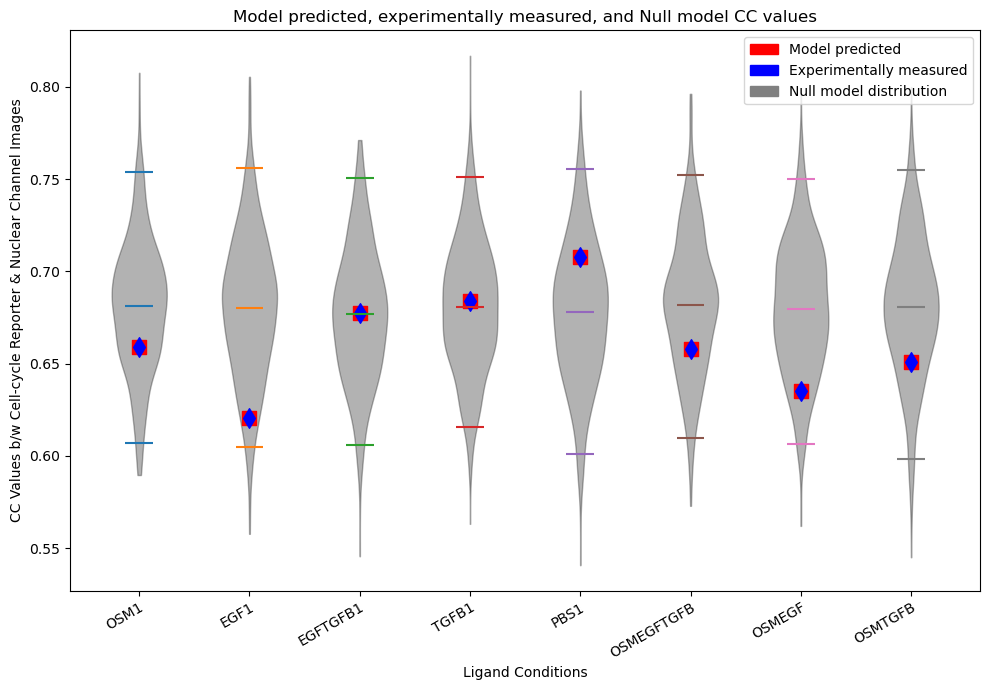

In [14]:
plt.clf()
plt.figure(figsize = (10, 7))
ax = plt.gca()
visual = False

cross_corr_rep_nuc_all = bulk_cc_values
n_states = state_probs.shape[1] # Number of Macroscopic (morphodynamic) states

lb = np.zeros(n_states)
ub = np.ones(n_states)*np.inf
        
get_counts = True
if get_counts:
    cross_corr_rep_nuc_states = get_state_decomposition(cross_corr_rep_nuc_all, state_probs, ncombinations=500,
                                                        inds_tm_training=inds_tmfSet_Imaging, 
                                                        save_file=None)
else:
    cross_corr_rep_nuc_states = np.load('statDecom_'+figid+LOCO+'.npy')

# Predict cross-correlation values
cross_corr_rep_nuc_predicted = get_predictedFC(state_probs, cross_corr_rep_nuc_states)
        
corrSet_pred = cross_corr_rep_nuc_predicted 
corrSet_real = cross_corr_rep_nuc_all # cross-correlation values
print(f"Model predicted: {corrSet_pred}, Experimentally measured: {corrSet_real}")
######################### how unique are state probabilities #########################
n_random = 500
corrSet_rand = np.zeros((n_random, n_states)) # Correlation of NULL model and real values
for ir in range(nrandom):
    state_probs_r = np.zeros_like(state_probs) # state probabilities random -> NULL model
    for itr in range(n_conditions):
        rp = np.random.rand(n_states) # Random probability of each training set  
        rp = rp/np.sum(rp)
        state_probs_r[itr, :] = rp.copy()
    cross_corr_rep_nuc_null = get_predictedFC(state_probs_r, cross_corr_rep_nuc_states) # cross-correlations @ NULL model state probabilities
    corrSet_rand[ir] = cross_corr_rep_nuc_null # cross-correlation values of test set(s) from the NULL model 

# Calculate the mean and standard deviation of the null model distribution
null_mean = np.mean(corrSet_rand)
null_std = np.std(corrSet_rand)
# Calculate Z-scores for model prediction and experimentally measured
z_score_mod_pred = z_score(corrSet_pred, null_mean, null_std)
z_score_exp_measured = z_score(corrSet_real, null_mean, null_std)

################################# Plot model predictions  ################################
positions_violin = np.arange(corrSet_rand.shape[1]) + 1
for cond_indc in range(n_conditions):

    vplot = ax.violinplot(corrSet_rand[:, cond_indc],
                          positions=[positions_violin[cond_indc]],
                          showmeans=True,
                          showextrema=False,
                          quantiles=[.025, .975])

    for pc in vplot['bodies']:
        pc.set_facecolor('black')
        pc.set_edgecolor('black')

    plt.scatter(positions_violin[cond_indc], corrSet_pred[cond_indc], 
                s=100, c = 'red', marker = 's')
    plt.scatter(positions_violin[cond_indc], corrSet_real[cond_indc],
                s=100, c = 'blue', marker = 'd')

# custom legend handles
red_patch = mpatches.Patch(color='red', label='Model predicted')
blue_patch = mpatches.Patch(color='blue', label='Experimentally measured')
black_patch = mpatches.Patch(color='grey', label='Null model distribution') 

# Assuming you want to add these to your existing legend
plt.legend(handles=[red_patch, blue_patch, black_patch], loc='best')
#plt.legend(loc='best')
ax.set_xticks(np.arange(1, len(inds_tmfSet_Imaging) + 1))
ax.set_xticklabels(np.array(tmfSet)[inds_tmfSet_Imaging])
plt.setp(ax.get_xticklabels(), rotation = 30, ha = "right", rotation_mode = "anchor")
plt.ylabel('CC Values b/w Cell-cycle Reporter & Nuclear Channel Images')
plt.xlabel('Ligand Conditions')
plt.title('Model predicted, experimentally measured, and Null model CC values')
#plt.ylim(-1., 1.)
plt.tight_layout()
#plt.savefig(figid+'_ccValsPC'+str(nPCs)+'u'+str(nUMP)+wellInfo+'.png', dpi = 300, bbox_inches = 'tight')
plt.show()
plt.close()

In [ ]:
plt.clf()
plt.figure(figsize = (9, 6))
ax = plt.gca()
visual = False
loco = True

dumpFile = figid+'_LOCO_ccVals_macStatesPC'+str(nPCs)+'u'+str(nUMP)+wellInfo+'.dat'
with open(dumpFile, 'a') as fp:
    for iTest in range(n_conditions):
        ################# MODIFY INDICES AND DATA ACCORDING TO WHETHER A CONDITION IS EXCLUDED FROM TRAINING #################
        inds_tm_training = np.arange(n_conditions).astype(int) 
        inds_tm_test = np.array([iTest]).astype(int) # leaving one "LIGAND" condition out (LOCO), just test from combo data
        LOCO = tmSet_imaging[inds_tm_test]
        LOCO = ''.join(LOCO) # convert string list to string
        inds_tm_training = np.setdiff1d(inds_tm_training, inds_tm_test) # remove LOCO index from the training set
        ############# Update state probabilities and log-fold change values as per "inds_tm_training" #############
        state_probs_loco = state_probs[inds_tm_training, :]
        cross_corr_rep_nuc_all = bulk_cc_values
        cross_corr_rep_nuc_loco = bulk_cc_values[inds_tm_training]
        #print("Cross correlations LOCO: ",cross_corr_rep_nuc_loco)
        inds_tmfSet_imaging = np.arange(len(inds_tm_training), dtype = int)
        inds_tm_training = inds_tmfSet_imaging # Update training indices after LOCO
        state_probs = state_probs_loco[inds_tmfSet_imaging, :] # state probabilities of the training set
        n_states = state_probs.shape[1] # Number of Macroscopic (morphodynamic) states 
        ntr = state_probs.shape[0] # Number of training conditions 
        state_probs = state_probs[inds_tmfSet_imaging, 0:n_states]
        ntr_training = inds_tm_training.size
        lb = np.zeros(n_states)
        ub = np.ones(n_states)*np.inf
        
        get_counts = True
        if get_counts:
            cross_corr_rep_nuc_states = get_state_decomposition(cross_corr_rep_nuc_loco, state_probs, ncombinations=500,
                                                                inds_tm_training=inds_tm_training, 
                                                                save_file=None)
                                                                #save_file='statDecom_'+figid+LOCO+'.npy')
        else:
            cross_corr_rep_nuc_states = np.load('statDecom_'+figid+LOCO+'.npy')
        #print(cross_corr_rep_nuc_states)
        # Predict cross-correlation values of the test set whereas the model was trained on remaining conditions (training set)
        state_probs_LOCO = state_probs_[inds_tm_test, 0:n_states] # State probabilities of the "Test Set"
        cross_corr_rep_nuc_predicted = get_predictedFC(state_probs_LOCO, cross_corr_rep_nuc_states)
         
        nConds_test = len(inds_tm_test) # Number of Ligand conditions in "Test Set"
        
        corrSet_pred = cross_corr_rep_nuc_predicted # cross-correlation values prediction of test set(s)
        corrSet_real = cross_corr_rep_nuc_all[iTest] # cross-correlation values of test condition(s)
        ######################### how unique are state probabilities #########################
        nrandom = 500
        corrSet_rand = np.zeros(nrandom) # Correlation of NULL model and real values
        for ir in range(nrandom):
            state_probs_r = np.zeros_like(state_probs_LOCO) # state probabilities random -> NULL model
            for itr in range(nConds_test):
                rp = np.random.rand(n_states) # Random probability of each training set  
                rp = rp/np.sum(rp)
                state_probs_r[itr, :] = rp.copy()
            cross_corr_rep_nuc_null = get_predictedFC(state_probs_r, cross_corr_rep_nuc_states) # cross-correlations as per NULL model state probabilities
            corrSet_rand[ir] = cross_corr_rep_nuc_null # cross-correlation values of test set(s) from the NULL model 
                
        # Calculate the mean and standard deviation of the null model distribution
        null_mean = np.mean(corrSet_rand)
        null_std = np.std(corrSet_rand)
        # Calculate Z-scores for model prediction and experimentally measured
        z_score_mod_pred = z_score(corrSet_pred, null_mean, null_std)
        z_score_exp_measured = z_score(corrSet_real, null_mean, null_std)
         
        fp.write(f"Z-score of Model Prediction: {z_score_mod_pred}, and experimentally measured: {z_score_exp_measured}\n")    
         
        ################################# Plot model predictions for LOCO  ################################
        vplot = ax.violinplot(corrSet_rand[:], positions = [iTest + 1],
                              showmeans = True, showextrema = False, quantiles = [.025, .975])
        for partname in ('cmeans', 'cquantiles'):
            vp = vplot[partname]
            vp.set_edgecolor('black')
        if iTest == 0:
           plt.scatter(iTest + 1, corrSet_pred, s=100, c = 'red', marker = 'd', label = 'Model predicted')
           plt.scatter(iTest + 1, corrSet_real, s=100, c = 'blue', marker = 'd', label = 'Experimentally measured')
           plt.legend(loc='best')
        else:   
           plt.scatter(iTest + 1, corrSet_pred, s=100, c = 'red', marker = 'd')
           plt.scatter(iTest + 1, corrSet_real, s=100, c = 'blue', marker = 'd')
        for pc in vplot['bodies']:
            pc.set_facecolor('black')
            pc.set_edgecolor('black')
            # pc.set_alpha(1)
        plt.pause(.1)
ax.set_xticks(np.arange(1, len(inds_tmfSet_Imaging) + 1))
ax.set_xticklabels(np.array(tmfSet)[inds_tmfSet_Imaging])
plt.setp(ax.get_xticklabels(), rotation = 30, ha = "right", rotation_mode = "anchor")
plt.ylabel('Cross correlations')
plt.title('Model predicted, experimentally measured, and Null model cross-correlations')
#plt.ylim(-1., 1.)
plt.tight_layout()
#plt.savefig(figid+'_LOCO_crosCorrPC'+str(nPCs)+'u'+str(nUMP)+wellInfo+'wellsComb.png', dpi = 300, bbox_inches = 'tight')
plt.show()
plt.close()

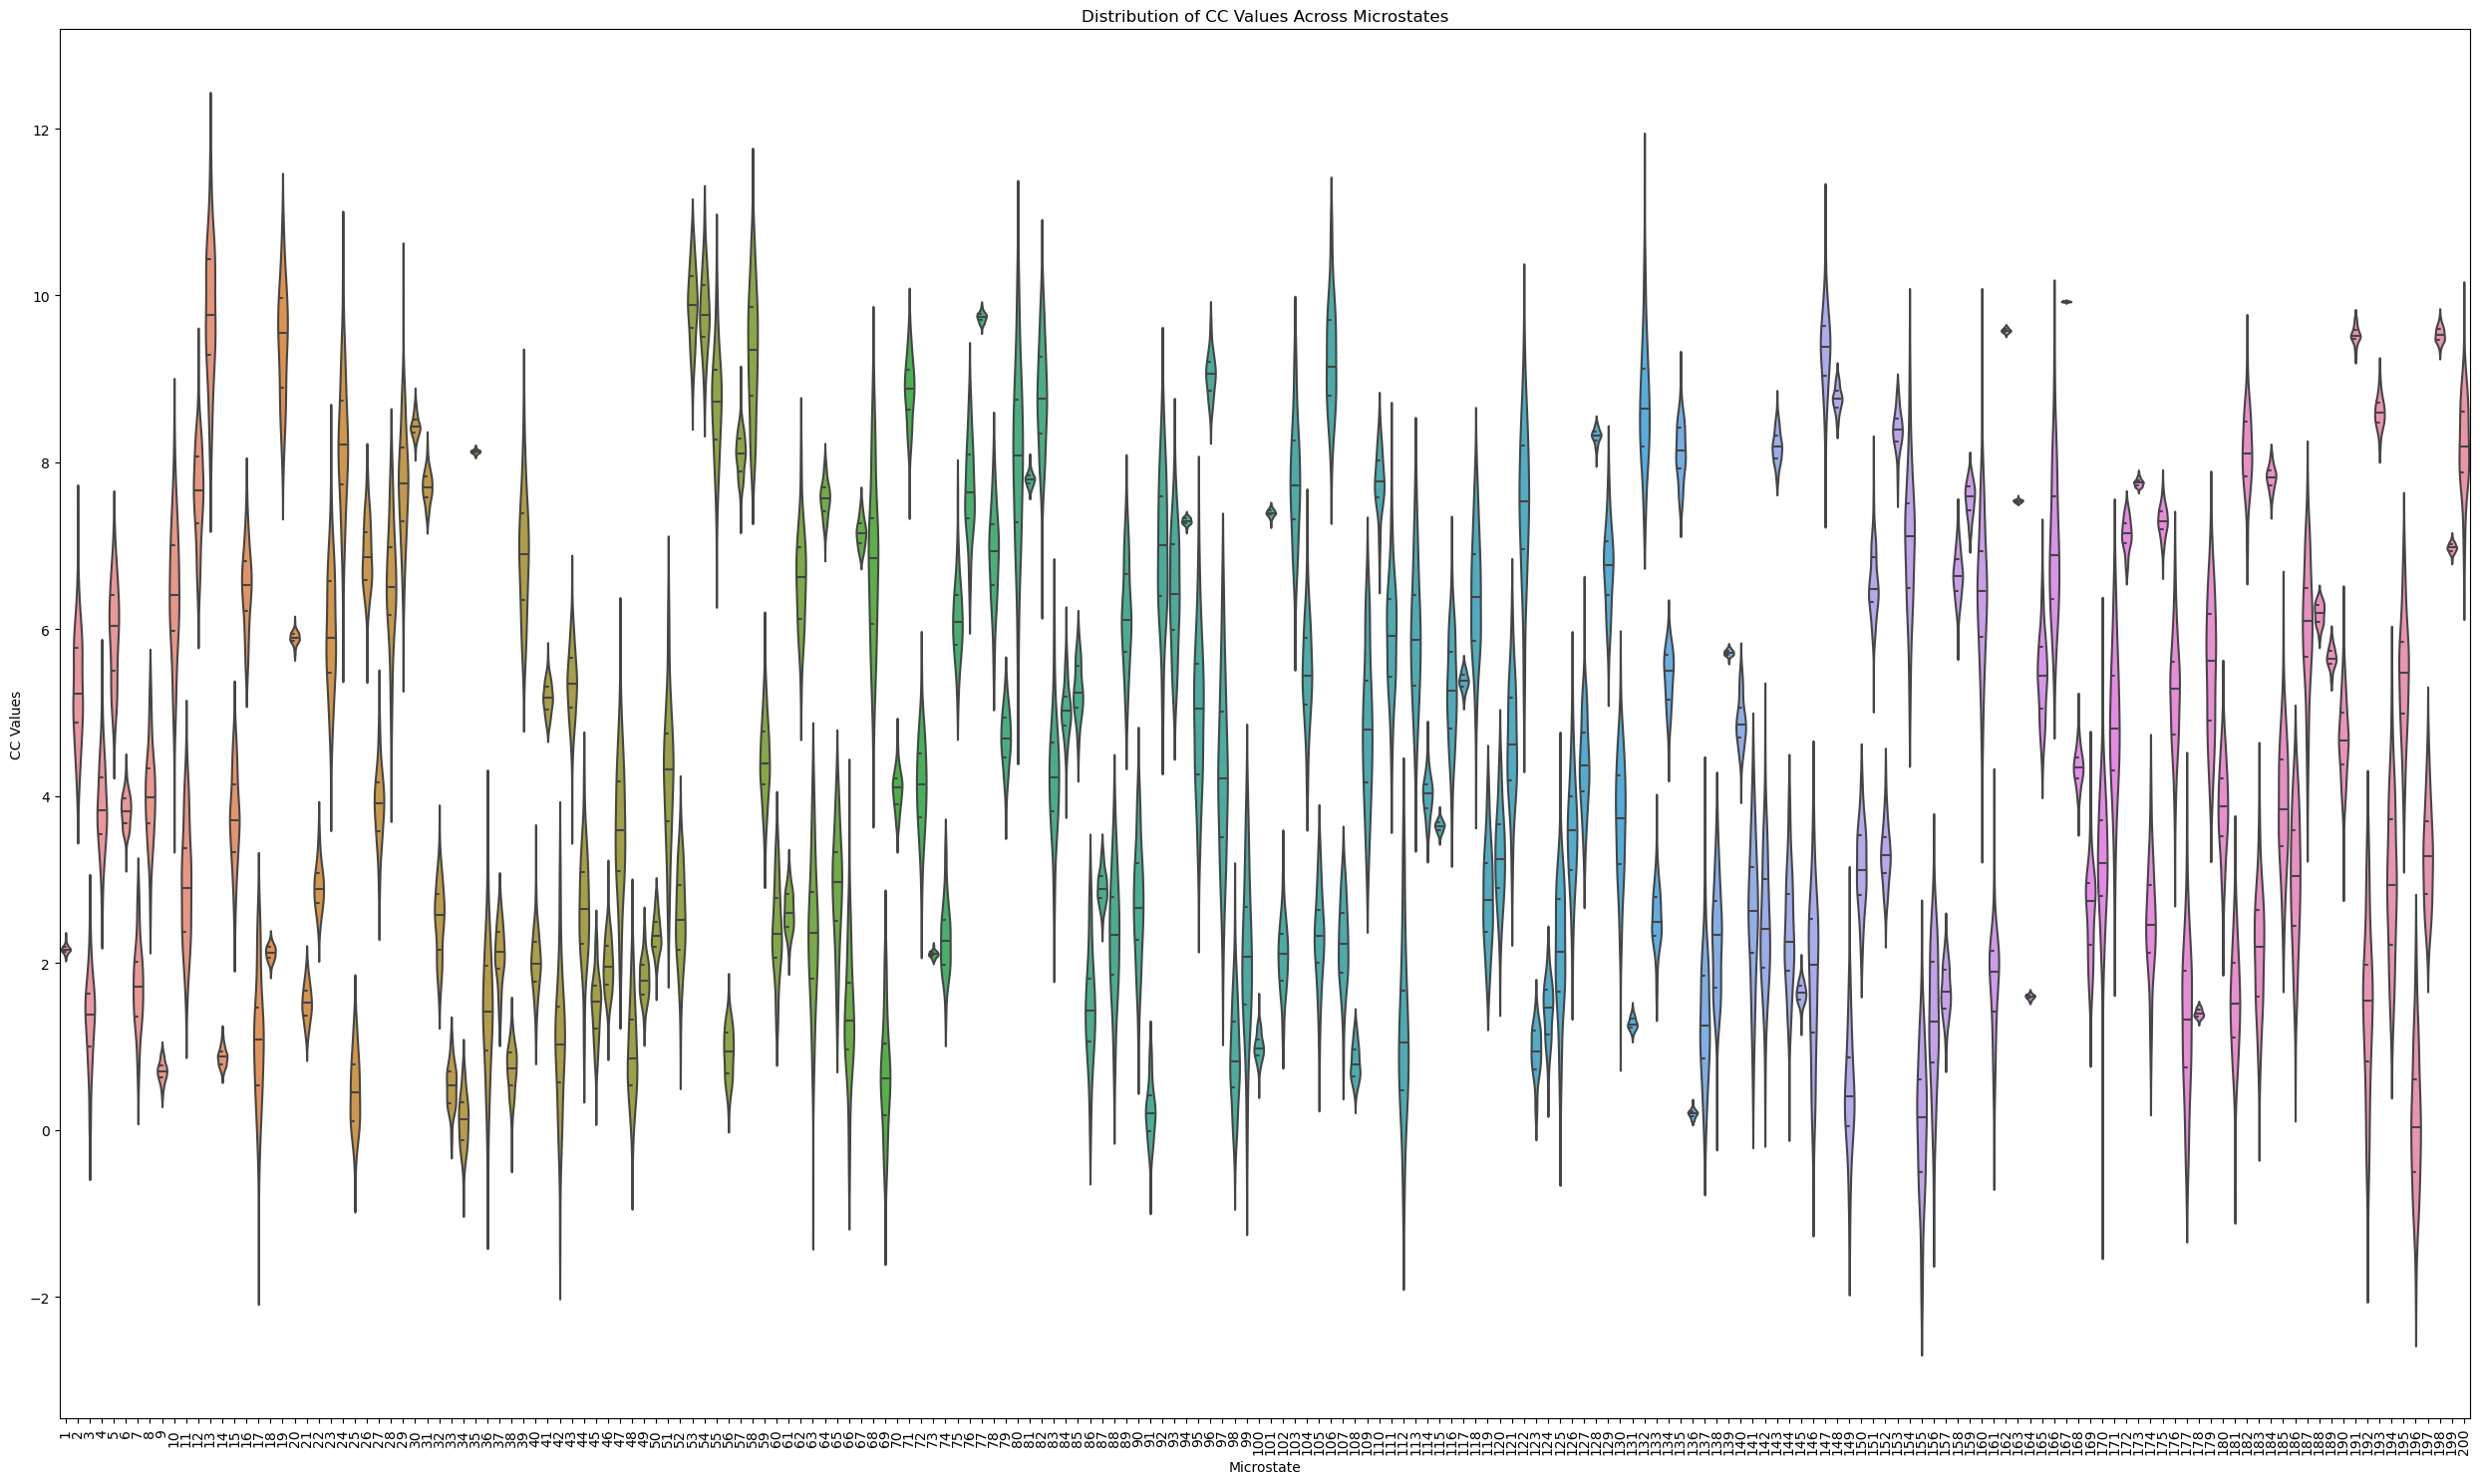

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

# Generate example data
# Assuming `all_values` is a dictionary with keys as microstate indices (1 to 200) and values as lists of CC values
all_values = {i: np.random.normal(loc=np.random.rand()*10, scale=np.random.rand(), size=100) for i in range(1, 201)}

# Preparing data for Seaborn
microstate_indices = []
cc_values = []

for microstate, values in all_values.items():
    microstate_indices.extend([microstate] * len(values))
    cc_values.extend(values)

import pandas as pd
data = pd.DataFrame({
    'Microstate': microstate_indices,
    'CC Values': cc_values
})

# Plotting
plt.figure(figsize=(25, 15))
sns.violinplot(x='Microstate', y='CC Values', data=data, scale='width', inner='quartile')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.title('Distribution of CC Values Across Microstates')
plt.xlabel('Microstate')
plt.ylabel('CC Values')
plt.tight_layout()
plt.show()
